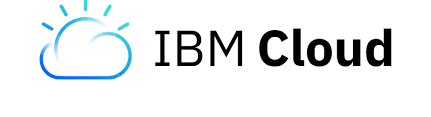

# Spark Machine Learning

Keep the main [Spark ML documentation](https://spark.apache.org/docs/latest/ml-pipeline.html) as you go through this tutorial.  MLlib is Spark’s machine learning (ML) library. **Spark ML** is not an official name, but we will use it to refer to the MLlib DataFrame-based API that embraces ML pipelines. Before we get into Spark ML by demonstrating a couple of examples we will first review Spark DataFrames.

In [3]:
import re
import os
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn')
%matplotlib inline

DATA_DIR = os.path.join("..","data")

## Spark SQL and DataFrames

What is Spark SQL?
- Spark SQL takes basic RDDs and **puts a schema on them**.

What is a DataFrame?
- DataFrames are the primary abstraction in Spark SQL.
- Think of a DataFrames as **RDDs with schema**.

What are **schemas**?
- Schemas are metadata about your data.
- Schema = Table Names + Column Names + Column Types

What are the pros of schemas?
- Schemas enable using **column names** instead of column positions
- Schemas enable **queries** using SQL and DataFrame syntax
- Schemas make your data more **structured**.

See the [Spark SQL documentation](https://spark.apache.org/docs/latest/sql-programming-guide.html) as a main point of reference for Spark SQL, DataFrames and Datasets.

## Creating DataFrames

You can create a DataFrame from an existing RDD (whatever source you used to create this one), if you add a schema.

To build a schema, you will use existing data types provided in the [`pyspqrk.sql.types`](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.types) module.  

<center>
<table style="width:50%">
  <tr>
      <th>Types</th>
      <th>Python Equivalent</th>
    </tr>
  <tr>
      <td>StringType</td>
      <td>string</td>
  </tr>
  <tr>
      <td>IntegerType</td>
      <td>integer</td>
   <tr>
      <td>FloatType</td>
      <td>float</td> 
  <tr>
      <td>ArrayType</td>
      <td>array or list</td>
   </tr>
    <tr>
      <td>MapType</td>
      <td>dict</td>
   </tr>       
</table>
</center>

First we initialize the Spark Environment

In [2]:
import pyspark as ps

spark = ps.sql.SparkSession.builder \
            .master("local[4]") \
            .appName("spark-ml-examples") \
            .getOrCreate()

sc = spark.sparkContext

the `local[4]` will create a `local` cluster made of the driver using all 4 cores.  Lets start with a very small file to to demonstrate the different ways to create Spark DataFrames.

In [4]:
def casting_function(args):
    user_id, date, num_streams, country, invoice_item = args
    return((int(user_id), date, int(num_streams), country, int(invoice_item)))

rdd_aavail = sc.textFile(os.path.join(DATA_DIR, 'example-data.csv'))\
                         .map(lambda rowstr : rowstr.split(","))\
                         .filter(lambda row: not row[0].startswith('#'))\
                         .map(casting_function)

rdd_aavail.collect()

[(111, '10/13/2019', 4, 'US', 1),
 (122, '10/15/2019', 5, 'SG', 1),
 (102, '10/16/2019', 11, 'US', 1),
 (144, '10/25/2019', 14, 'US', 2),
 (121, '10/26/2019', 7, 'SG', 1),
 (155, '10/27/2019', 9, 'US', 3)]

You can create a Spark DataFrame using a schema that you have defined or it can be inferred.  To create your own. 

In [5]:
from pyspark.sql.types import *

schema = StructType([
    StructField('user_id', IntegerType(), True),
    StructField('date', StringType(), True),
    StructField('num_streams', IntegerType(), True),
    StructField('country', StringType(), True),
    StructField('invoice_items', IntegerType(), True) ])
    
# feed that into a DataFrame
df = spark.createDataFrame(rdd_aavail, schema)

# show the result
df.show()

# print the schema
df.printSchema()  

+-------+----------+-----------+-------+-------------+
|user_id|      date|num_streams|country|invoice_items|
+-------+----------+-----------+-------+-------------+
|    111|10/13/2019|          4|     US|            1|
|    122|10/15/2019|          5|     SG|            1|
|    102|10/16/2019|         11|     US|            1|
|    144|10/25/2019|         14|     US|            2|
|    121|10/26/2019|          7|     SG|            1|
|    155|10/27/2019|          9|     US|            3|
+-------+----------+-----------+-------+-------------+

root
 |-- user_id: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- num_streams: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- invoice_items: integer (nullable = true)



You may also read the data directly from a file and **infer** the schema

In [8]:
# read CSV
df = spark.read.csv(os.path.join(DATA_DIR, 'example-data.csv'),
                         header=True,       # use headers or not
                         quote='"',         # char for quotes
                         sep=",",           # char for separation
                         inferSchema=True)  # do we infer schema or not ?


# some functions are still valid
print("line count: {}".format(df.count()))

# show the table in a nice format
df.show()

# prints the schema
df.printSchema()

line count: 6
+-----+----------+-----------+-------+------------+
|#user|      date|num_streams|country|invoice_item|
+-----+----------+-----------+-------+------------+
|  111|10/13/2019|          4|     US|           1|
|  122|10/15/2019|          5|     SG|           1|
|  102|10/16/2019|         11|     US|           1|
|  144|10/25/2019|         14|     US|           2|
|  121|10/26/2019|          7|     SG|           1|
|  155|10/27/2019|          9|     US|           3|
+-----+----------+-----------+-------+------------+

root
 |-- #user: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- num_streams: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- invoice_item: integer (nullable = true)



You can turn the DataFrame into a Panda DataFrame, but be careful since this 'action' will put all the data into memory

In [9]:
df.toPandas()

,#user,date,num_streams,country,invoice_item
0,111,10/13/2019,4,US,1
1,122,10/15/2019,5,SG,1
2,102,10/16/2019,11,US,1
3,144,10/25/2019,14,US,2
4,121,10/26/2019,7,SG,1
5,155,10/27/2019,9,US,3


Here are some common operations that you might perform on a DataFrame

In [10]:
# prints the schema
print("--- printSchema()")
df.printSchema()

# prints the table itself
print("--- show()")
df.show()

# show the statistics of all numerical columns
print("--- describe()")
df.describe().show()

# show the statistics of one specific column
print("--- describe(Amount)")
df.describe("num_streams").show()

--- printSchema()
root
 |-- #user: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- num_streams: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- invoice_item: integer (nullable = true)

--- show()
+-----+----------+-----------+-------+------------+
|#user|      date|num_streams|country|invoice_item|
+-----+----------+-----------+-------+------------+
|  111|10/13/2019|          4|     US|           1|
|  122|10/15/2019|          5|     SG|           1|
|  102|10/16/2019|         11|     US|           1|
|  144|10/25/2019|         14|     US|           2|
|  121|10/26/2019|          7|     SG|           1|
|  155|10/27/2019|          9|     US|           3|
+-----+----------+-----------+-------+------------+

--- describe()
+-------+------------------+----------+-----------------+-------+------------------+
|summary|             #user|      date|      num_streams|country|      invoice_item|
+-------+------------------+----------+-----------------+

## Transformations on DataFrames

- They are still **lazy**: Spark doesn't apply the transformation right away, it just builds on the **DAG**
- They transform a DataFrame into another because DataFrames are also **immutable**.
- They can be **wide** or **narrow** (whether they shuffle partitions or not).


Lets read in in the AAVAIL dataset that we have been working with to demonstrate the transformations.

In [12]:
# read CSV
df_aavail = spark.read.csv(os.path.join(DATA_DIR, 'aavail-target.csv'),
                           header=True,       
                           quote='"',         
                           sep=",",          
                           inferSchema=True)
df_aavail.describe().show()

+-------+-----------------+------------------+-------------+------------------+--------------+----------------+-----------------+
|summary|      customer_id|     is_subscriber|      country|               age| customer_name| subscriber_type|      num_streams|
+-------+-----------------+------------------+-------------+------------------+--------------+----------------+-----------------+
|  count|             1000|              1000|         1000|              1000|          1000|            1000|             1000|
|   mean|            500.5|             0.711|         null|            25.325|          null|            null|           17.695|
| stddev|288.8194360957494|0.4535247343692345|         null|12.184655959067568|          null|            null|4.798020007877829|
|    min|                1|                 0|    singapore|               -50|Aaliyah Duarte|    aavail_basic|                1|
|    max|             1000|                 1|united_states|                50|   Zoie Cor

## Remove one or more columns

In [13]:
columns_to_drop = ['customer_id', 'customer_name']
df_aavail = df_aavail.drop(*columns_to_drop)
df_aavail.describe().show()
df_aavail.groupBy("subscriber_type").count().show()

+-------+------------------+-------------+------------------+----------------+-----------------+
|summary|     is_subscriber|      country|               age| subscriber_type|      num_streams|
+-------+------------------+-------------+------------------+----------------+-----------------+
|  count|              1000|         1000|              1000|            1000|             1000|
|   mean|             0.711|         null|            25.325|            null|           17.695|
| stddev|0.4535247343692345|         null|12.184655959067568|            null|4.798020007877829|
|    min|                 0|    singapore|               -50|    aavail_basic|                1|
|    max|                 1|united_states|                50|aavail_unlimited|               29|
+-------+------------------+-------------+------------------+----------------+-----------------+

+----------------+-----+
| subscriber_type|count|
+----------------+-----+
|  aavail_premium|  331|
|aavail_unlimited|  302|
|

## Transformations on a feature matrix

The following example demonstrates how to deal with categorical features and scale continuous ones

In [15]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline

## scale the continuous features
va = VectorAssembler(inputCols=["age", "num_streams"], outputCol="cont_features")
ss = standardScaler = StandardScaler(inputCol="cont_features", outputCol="cont_scaled")

## categorical variable transformation
cat_cols = ["country", "subscriber_type"]
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in cat_cols]
encoders = [OneHotEncoder(inputCol=column+"_index", outputCol=column+"_oh") for column in cat_cols]

## assemple the features for input into the ML model
assembler = VectorAssembler(inputCols=["cont_scaled", "country_oh", "subscriber_type_oh"], outputCol="features")

## setup a model
gbt = GBTClassifier(labelCol="is_subscriber", featuresCol="features")
paramMap = {gbt.maxIter: 20}

## Setup the pipeline and train the model

In [17]:
## run the whole pipeline
pipe = Pipeline(stages=indexers+encoders+[va, ss, assembler, gbt])
result = pipe.fit(df_aavail, paramMap).transform(df_aavail)
result.select("features", "is_subscriber", "rawPrediction", "probability", "prediction").show()

+--------------------+-------------+--------------------+--------------------+----------+
|            features|is_subscriber|       rawPrediction|         probability|prediction|
+--------------------+-------------+--------------------+--------------------+----------+
|[1.72347910934425...|            1|[-0.7104551723677...|[0.19451890992497...|       1.0|
|(5,[0,1],[2.46211...|            0|[0.77502044150328...|[0.82491963653378...|       0.0|
|[1.72347910934425...|            0|[-0.7104551723677...|[0.19451890992497...|       1.0|
|[1.64140867556596...|            1|[-0.9291971347680...|[0.13489032271470...|       1.0|
|[1.72347910934425...|            1|[0.00233192525665...|[0.50116596051488...|       0.0|
|[1.72347910934425...|            1|[-0.7703335442768...|[0.17643832065912...|       1.0|
|[3.93938082135830...|            0|[0.74986801956411...|[0.81753510406590...|       0.0|
|[3.85731038758001...|            1|[-0.9215852644165...|[0.13667675103731...|       1.0|
|[1.723479

Now the same procedure with a train-test split, cross-validations and grid-search

In [18]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

train, test = df_aavail.randomSplit([0.8, 0.2], seed=42)

gbt = GBTClassifier(labelCol="is_subscriber", featuresCol="features")
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20]) \
    .addGrid(gbt.stepSize, [0.01, 0.1]) \
    .build()

pipe = Pipeline(stages=indexers+encoders+[va, ss, assembler])
pipeline_model = pipe.fit(train)
prepped_train = pipeline_model.transform(train)
prepped_test = pipeline_model.transform(test)

crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="is_subscriber"),
                          numFolds=3)

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(prepped_train)
print("model trained")

model trained


In [19]:
prediction = cvModel.transform(prepped_test)
result = prediction.select("features", "is_subscriber", "rawPrediction", "probability", "prediction")
result.show()

+--------------------+-------------+--------------------+--------------------+----------+
|            features|is_subscriber|       rawPrediction|         probability|prediction|
+--------------------+-------------+--------------------+--------------------+----------+
|[-3.7470583658643...|            0|[-0.6122334251753...|[0.22715132332772...|       1.0|
|[1.22186685843403...|            0|[0.58923177628985...|[0.76467143397888...|       0.0|
|[1.38478243955857...|            0|[-0.3870220996122...|[0.31560491476966...|       1.0|
|(5,[0,1],[1.38478...|            0|[0.03722032463014...|[0.51860157319592...|       0.0|
|[1.46624023012084...|            0|[0.40151039433208...|[0.69062028601309...|       0.0|
|[1.46624023012084...|            0|[0.54839574757100...|[0.74965844583331...|       0.0|
|[1.54769802068311...|            0|[0.06384805666974...|[0.53188071873051...|       0.0|
|(5,[0,1],[1.54769...|            0|[0.06384805666974...|[0.53188071873051...|       0.0|
|[1.629155